In [39]:
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split 
import pandas as pd 
import numpy as np 
import keras_tuner as kt 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from sklearn.metrics import (accuracy_score, roc_curve, auc, precision_recall_curve, 
                             confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, 
                             classification_report, recall_score, balanced_accuracy_score, f1_score, precision_score)
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Normalization, StringLookup
import seaborn as sns

In [3]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\sms.csv",
                  encoding ='latin1',
                  header = None,
                  names =['label','text',1,2,3]);

df = df.drop(columns=[1,2,3]);

df = df.drop(index=0).reset_index(drop=True)

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
lookup = tf.keras.layers.StringLookup(num_oov_indices=0)
lookup.adapt(df['label'])
df['label'] = lookup(df['label'])

In [11]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


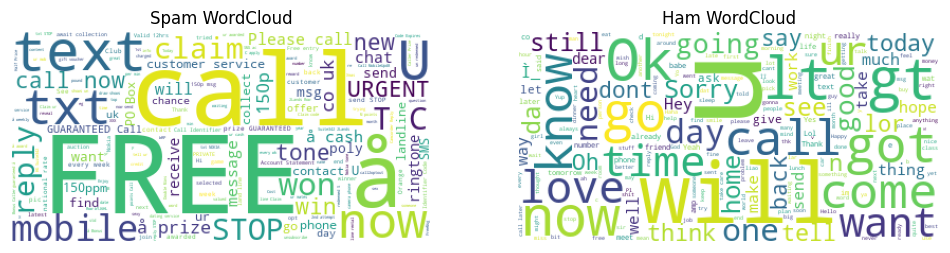

In [12]:
spam_text = " ".join(df[df['label'] == 1]['text']) 
ham_text = " ".join(df[df['label'] == 0]['text'])

plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1) 
plt.imshow(WordCloud(width=400, height=200, background_color='white').generate(spam_text)) 
plt.title("Spam WordCloud") 
plt.axis("off")

plt.subplot(1, 2, 2) 
plt.imshow(WordCloud(width=400, height=200, background_color='white').generate(ham_text)) 
plt.title("Ham WordCloud") 
plt.axis("off") 
plt.show()

In [15]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>") 
tokenizer.fit_on_texts(df['text']) 
sequences = tokenizer.texts_to_sequences(df['text']) 
padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

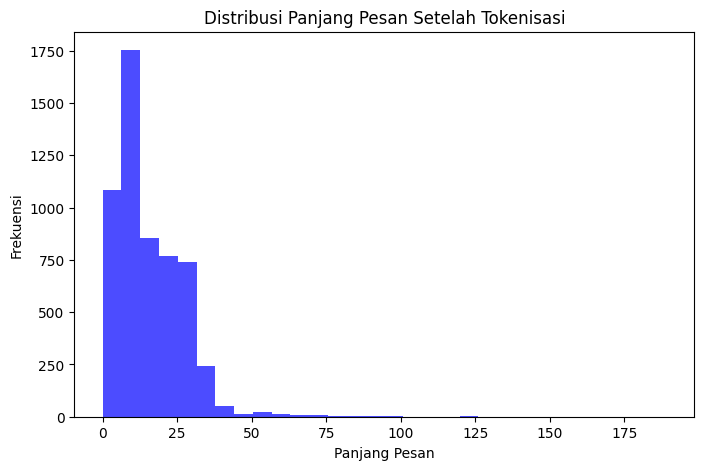

In [16]:
message_lengths = [len(seq) for seq in sequences] 
plt.figure(figsize=(8, 5)) 
plt.hist(message_lengths, bins=30, color='blue', alpha=0.7) 
plt.xlabel("Panjang Pesan") 
plt.ylabel("Frekuensi") 
plt.title("Distribusi Panjang Pesan Setelah Tokenisasi") 
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(padded, df['label'], test_size=0.2, random_state=42)

In [21]:
def build_model(hp): 
    model = keras.Sequential() 
    model.add(layers.Embedding(input_dim=10000, output_dim=hp.Int('embedding_dim', 16, 64))) 
    model.add(layers.Conv1D(filters=hp.Int('filters', 32, 128, step=32), kernel_size=hp.Choice('kernel_size', [3, 5]), activation='relu')) 
    model.add(layers.GlobalMaxPooling1D()) 
    model.add(layers.Dense(hp.Int('units', 16, 128, step=16), activation='relu')) 
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4])), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

In [22]:
tuner = kt.Hyperband(
    build_model, 
    objective='val_loss', 
    max_epochs=50, 
    factor=3, 
    directory='my_dir', 
    project_name='spam_detection'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6
    )

In [23]:
tuner.search(X_train, y_train,
             validation_split=0.2, epochs = 50,
             batch_size = 16, verbose=1)

Trial 90 Complete [00h 02m 07s]
val_loss: 0.0642029270529747

Best val_loss So Far: 0.05229240283370018
Total elapsed time: 01h 31m 50s


In [25]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train,
                         validation_split=0.2,
                         epochs=50,
                         batch_size=16,
                         verbose=True)

Epoch 1/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8656 - loss: 0.5864 - val_accuracy: 0.8621 - val_loss: 0.3977
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8726 - loss: 0.3769 - val_accuracy: 0.8621 - val_loss: 0.3915
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8726 - loss: 0.3661 - val_accuracy: 0.8621 - val_loss: 0.3695
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8775 - loss: 0.3279 - val_accuracy: 0.8621 - val_loss: 0.2942
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8709 - loss: 0.2534 - val_accuracy: 0.9462 - val_loss: 0.1639
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9603 - loss: 0.1299 - val_accuracy: 0.9787 - val_loss: 0.0954
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9847 - loss: 0.0639 - val_accuracy: 0.9821 - val_loss: 0.0710
Epoch 8/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9878 - loss: 0.0412 - val_accu

In [26]:
y_predict = best_model.predict(X_test)
y_pred = (y_predict >= 0.5).astype(int)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Text(113.9222222222222, 0.5, 'true value')

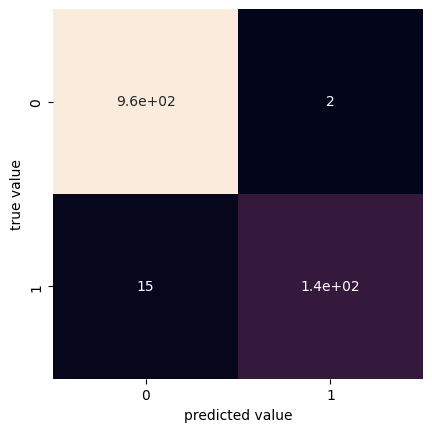

In [29]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, square  =True, annot = True, cbar = False)
plt.xlabel('predicted value')
plt.ylabel('true value')

In [30]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9847533632286996

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.99      0.90      0.94       150

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



0.9937202072538861


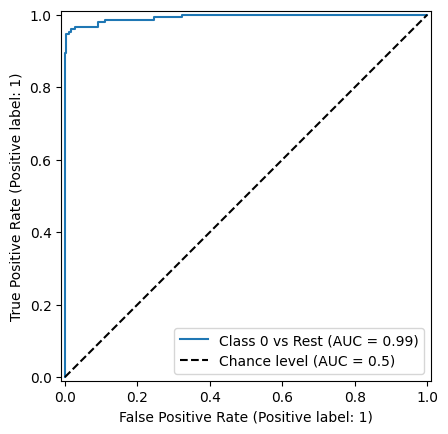

In [41]:
roc_auc_ovr = roc_auc_score(y_test, y_predict, multi_class='ovr')
print(roc_auc_ovr)
classes = np.unique(y_test)

y_test_bin = label_binarize(y_test, classes = classes)
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:,i],
        y_predict[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

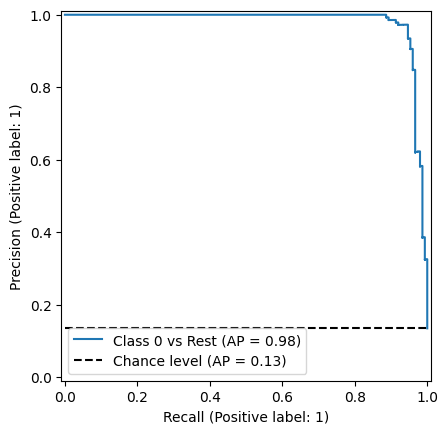

In [43]:
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:,i], y_predict[:,i])
    pr_auc[i] = auc(recall[i], precision[i])
    PrecisionRecallDisplay.from_predictions(
        y_test_bin[:,i],
        y_predict[:,i],
        name=f"Class {i} vs Rest",
        plot_chance_level =(i==0)
    )

plt.show()

In [44]:
print("\nModel Evaluation:")
results = best_model.evaluate(X_test, y_test, verbose=0)
metrics = dict(zip(best_model.metrics_names, results))
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


Model Evaluation:
loss: 0.0688
compile_metrics: 0.9848


140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


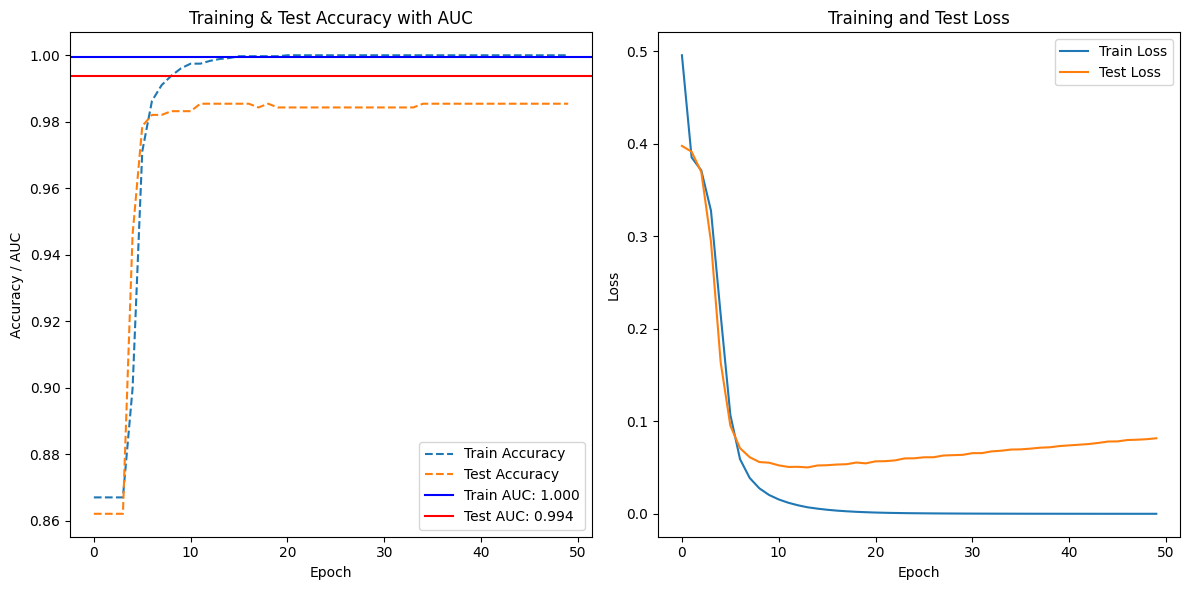

In [45]:
y_train_pred_prob = best_model.predict(X_train)
y_test_pred_prob = best_model.predict(X_test)

threshold = 0.5
y_train_pred = (y_train_pred_prob >= threshold).astype(int)
y_test_pred = (y_test_pred_prob >= threshold).astype(int)

y_train_true = y_train
y_test_true = y_test

train_auc = roc_auc_score(y_train_true, y_train_pred_prob, average='macro')
test_auc = roc_auc_score(y_test_true, y_test_pred_prob, average='macro')

train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_acc = history.history.get('accuracy', history.history.get('binary_accuracy'))
test_acc = history.history.get('val_accuracy', history.history.get('val_binary_accuracy'))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', linestyle='dashed')
plt.plot(test_acc, label='Test Accuracy', linestyle='dashed')
plt.axhline(train_auc, color='blue', linestyle='solid', label=f'Train AUC: {train_auc:.3f}')
plt.axhline(test_auc, color='red', linestyle='solid', label=f'Test AUC: {test_auc:.3f}')
plt.title('Training & Test Accuracy with AUC')
plt.ylabel('Accuracy / AUC')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print("\nAdvanced Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")


Advanced Metrics:
Precision: 0.9850
Recall (Sensitivity): 0.9490
F1 Score: 0.9660
Balanced Accuracy: 0.9490


In [47]:
print("\nAdvanced Metrics:")
print(f"- Maximum Training Accuracy: {max(train_acc):.4f}")
print(f"- Minimum Test Loss: {min(test_loss):.4f}")
print(f"- Optimal Epochs: {len(train_loss)}")
print(f"- Maximum Training AUC: {train_auc:.4f}")
print(f"- Test AUC: {test_auc:.4f}")


Advanced Metrics:
- Maximum Training Accuracy: 1.0000
- Minimum Test Loss: 0.0501
- Optimal Epochs: 50
- Maximum Training AUC: 0.9996
- Test AUC: 0.9937


In [50]:
best_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 24)        │       240,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 96)         │        11,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 96)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 764,261 (2.92 MB)

 Trainable params: 254,753 (995.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 509,508 (1.94 MB)